<a href="https://colab.research.google.com/github/TAUforPython/Graph-MachineLearning/blob/main/LLM%20Graph%20triplets%20visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/screemix/Wikontic/

# Load libraries

In [8]:
# Install required packages
!pip install -U mistralai python-dotenv pandas --quiet

In [15]:


# Load environment variables
_ = load_dotenv(find_dotenv())

# Get Mistral API credentials



from google.colab import userdata

# Get Hugging Face and PubMed token from environment
api_key = userdata.get("Mistral_API")
if api_key:
  print("✅ MISTRAL token detected")
else:
  print("⚠️  No MISTRAL TOKEN")


✅ MISTRAL token detected


In [25]:
from mistralai import Mistral
from dotenv import load_dotenv, find_dotenv
import os
import json
import pandas as pd
from datetime import datetime
import time
import re
from tenacity import retry, stop_after_attempt, wait_exponential


# LLM Misral chat generation

In [38]:
client = Mistral(api_key=api_key) # Initialize Mistral client

MODEL_NAME = "mistral-large-latest" # Or "open-mistral-7b", "open-mixtral-8x7b", etc.
NUM_SUPPORTED_CLAIMS = 300
NUM_REFUTED_CLAIMS = 300
MAX_RETRIES = 3
REQUEST_DELAY = 0.1 # Seconds between requests

# --- LLM Interaction Functions (with Retries) ---

@retry(stop=stop_after_attempt(MAX_RETRIES), wait=wait_exponential(multiplier=1, min=4, max=10))
def call_llm(prompt, model=MODEL_NAME):
    """Calls the Mistral LLM with a prompt, includes retry logic."""
    chat_response = client.chat.complete(
        model=model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant providing accurate information."},
            {"role": "user", "content": prompt}
        ],
        # Adjust parameters as needed
        max_tokens=500,
        temperature=0.1
    )
    # Mistral response structure is slightly different
    return chat_response.choices[0].message.content.strip()

class CSVTripletExtractor:
    """A simplified triplet extractor that stores data in CSV instead of MongoDB"""

    def __init__(self, api_key=None):
        if api_key:
            self.client = Mistral(api_key=api_key)
        else:
            self.client = Mistral(api_key=os.getenv("MISTRAL_API_KEY"))

        self.triplets_df = pd.DataFrame(columns=['id', 'subject', 'relation', 'object', 'qualifiers', 'subject_type', 'object_type', 'source_text_id', 'timestamp'])

    def extract_triplets_from_text(self, text, source_text_id=None):
        """Extract triplets from text using Mistral API"""
        prompt = f"""
        Extract factual triplets from the following text in the format (subject, relation, object).
        Also include qualifiers when present. Format as JSON with these fields:
        - subject: subject entity
        - relation: relation connecting subject and object
        - object: object entity
        - qualifiers: list of dicts with 'relation' and 'object'
        - subject_type: class describing subject entity
        - object_type: class describing object entity

        Text: {text}

        Return only valid JSON:
        """

        try:
            content = call_llm(prompt, MODEL_NAME)

            # Parse the response
            # Remove any markdown formatting
            if content.startswith('```json'):
                content = content[7:-3]  # Remove ```json and ```
            elif content.startswith('```'):
                content = content[3:-3]

            triplets_data = json.loads(content)

            # Convert to list if single triplet
            if isinstance(triplets_data, dict):
                triplets_data = [triplets_data]

            # Add to dataframe
            new_rows = []
            for i, triplet in enumerate(triplets_data):
                row = {
                    'id': f"{source_text_id}_{i}" if source_text_id else f"triplet_{len(self.triplets_df)}_{i}",
                    'subject': triplet.get('subject', ''),
                    'relation': triplet.get('relation', ''),
                    'object': triplet.get('object', ''),
                    'qualifiers': json.dumps(triplet.get('qualifiers', [])),
                    'subject_type': triplet.get('subject_type', ''),
                    'object_type': triplet.get('object_type', ''),
                    'source_text_id': source_text_id,
                    'timestamp': datetime.now().isoformat()
                }
                new_rows.append(row)

            if new_rows:
                new_df = pd.DataFrame(new_rows)
                self.triplets_df = pd.concat([self.triplets_df, new_df], ignore_index=True)

            time.sleep(REQUEST_DELAY)  # Rate limiting
            return triplets_data

        except Exception as e:
            print(f"Error extracting triplets: {e}")
            return []

    def save_to_csv(self, filename='triplets.csv'):
        """Save triplets to CSV file"""
        self.triplets_df.to_csv(filename, index=False)
        print(f"Triplets saved to {filename}")

    def load_from_csv(self, filename='triplets.csv'):
        """Load triplets from CSV file"""
        try:
            self.triplets_df = pd.read_csv(filename)
            print(f"Loaded triplets from {filename}")
        except FileNotFoundError:
            print(f"File {filename} not found. Starting with empty dataframe.")

    def search_triplets_by_entity(self, entity_name, case_sensitive=False):
        """Search for triplets containing a specific entity"""
        mask = (
            self.triplets_df['subject'].str.contains(entity_name, case=case_sensitive, na=False) |
            self.triplets_df['object'].str.contains(entity_name, case=case_sensitive, na=False)
        )
        return self.triplets_df[mask]

    def get_triplets_by_relation(self, relation):
        """Get all triplets with a specific relation"""
        return self.triplets_df[self.triplets_df['relation'] == relation]

class SimpleInferenceEngine:
    """Simple inference engine using CSV-stored triplets"""

    def __init__(self, extractor):
        self.extractor = extractor

    def answer_question(self, question, context_triplets=None):
        """Answer a question using stored triplets"""
        if context_triplets is None:
            context_triplets = self.extractor.triplets_df.to_dict('records')

        # Create a context string from triplets
        context_str = ""
        for triplet in context_triplets[:10]:  # Limit to first 10 triplets
            context_str += f"({triplet['subject']} {triplet['relation']} {triplet['object']})\n"

        prompt = f"""
        Based on the following facts, answer the question:

        Facts:
        {context_str}

        Question: {question}

        Answer concisely based only on the provided facts:
        """

        try:
            result = call_llm(prompt, MODEL_NAME)
            time.sleep(REQUEST_DELAY)  # Rate limiting
            return result

        except Exception as e:
            print(f"Error answering question: {e}")
            return "Could not generate answer."

# Initialize the system
extractor = CSVTripletExtractor()

# Example usage
text_1 = """
Patient presented with chest pain. ECG showed ST elevation in leads V2-V4, indicating an anterior myocardial infarction.
Cardiac enzymes were elevated.
"""

# Extract triplets from text
print("Extracting triplets from text...")
triplets = extractor.extract_triplets_from_text(text=text_1, source_text_id="1")
print(f"Extracted {len(triplets)} triplets:")
for triplet in triplets:
    print(f"  ({triplet.get('subject')} {triplet.get('relation')} {triplet.get('object')})")

# Save to CSV
extractor.save_to_csv('jobs_triplets.csv')

# Create inference engine
inference_engine = SimpleInferenceEngine(extractor)

# Answer questions
print("\nAnswering questions...")

# Find relevant triplets for the question "Who was Jobs?"
relevant_triplets = extractor.search_triplets_by_entity("patient")
answer1 = inference_engine.answer_question("What did the ECG show?", relevant_triplets.to_dict('records'))
print(f"Q: What did the ECG show?\nA: {answer1}\n")

# Find companies Jobs founded
company_triplets = extractor.get_triplets_by_relation("indicated")
answer2 = inference_engine.answer_question("What did ST elevation indicate?", company_triplets.to_dict('records'))
print(f"Q: What did ST elevation indicate?\nA: {answer2}\n")

# Process more text
text_2 = """The patient's history includes hypertension and hyperlipidemia. He is 65 years old and a smoker.
"""

print("Processing additional text...")
more_triplets = extractor.extract_triplets_from_text(text=text_2, source_text_id="2")
print(f"Extracted {len(more_triplets)} additional triplets")

# Update CSV
extractor.save_to_csv('jobs_triplets.csv')

# Answer question about companies founded
all_relevant_triplets = extractor.search_triplets_by_entity("patient")
companies_triplets = extractor.get_triplets_by_relation("includes")
combined_triplets = pd.concat([all_relevant_triplets, companies_triplets]).drop_duplicates()
final_answer = inference_engine.answer_question("What is the patient's history?", combined_triplets.to_dict('records'))
print(f"Q: What is the patient's history?\nA: {final_answer}\n")

# Show the complete triplets dataframe
print("Complete triplets DataFrame:")
print(extractor.triplets_df[['subject', 'relation', 'object']])

Extracting triplets from text...
Extracted 4 triplets:
  (Patient presented with chest pain)
  (ECG showed ST elevation)
  (ST elevation in leads V2-V4 indicating anterior myocardial infarction)
  (Cardiac enzymes were elevated)
Triplets saved to jobs_triplets.csv

Answering questions...
Q: What did the ECG show?
A: The provided facts do not include information about the ECG results. Therefore, the answer is:

**Insufficient information to determine what the ECG showed.**

Q: What did ST elevation indicate?
A: Since no facts were provided in your query, I cannot answer the question based on missing information.

**In general**, ST elevation on an ECG typically indicates **acute myocardial injury (e.g., ST-elevation myocardial infarction, or STEMI)**, but the exact interpretation depends on clinical context and supporting data.

If you provide the relevant facts, I can give a precise answer.

Processing additional text...
Extracted 4 additional triplets
Triplets saved to jobs_triplets.c

# Graph visualisation

Visualizing the knowledge graph...


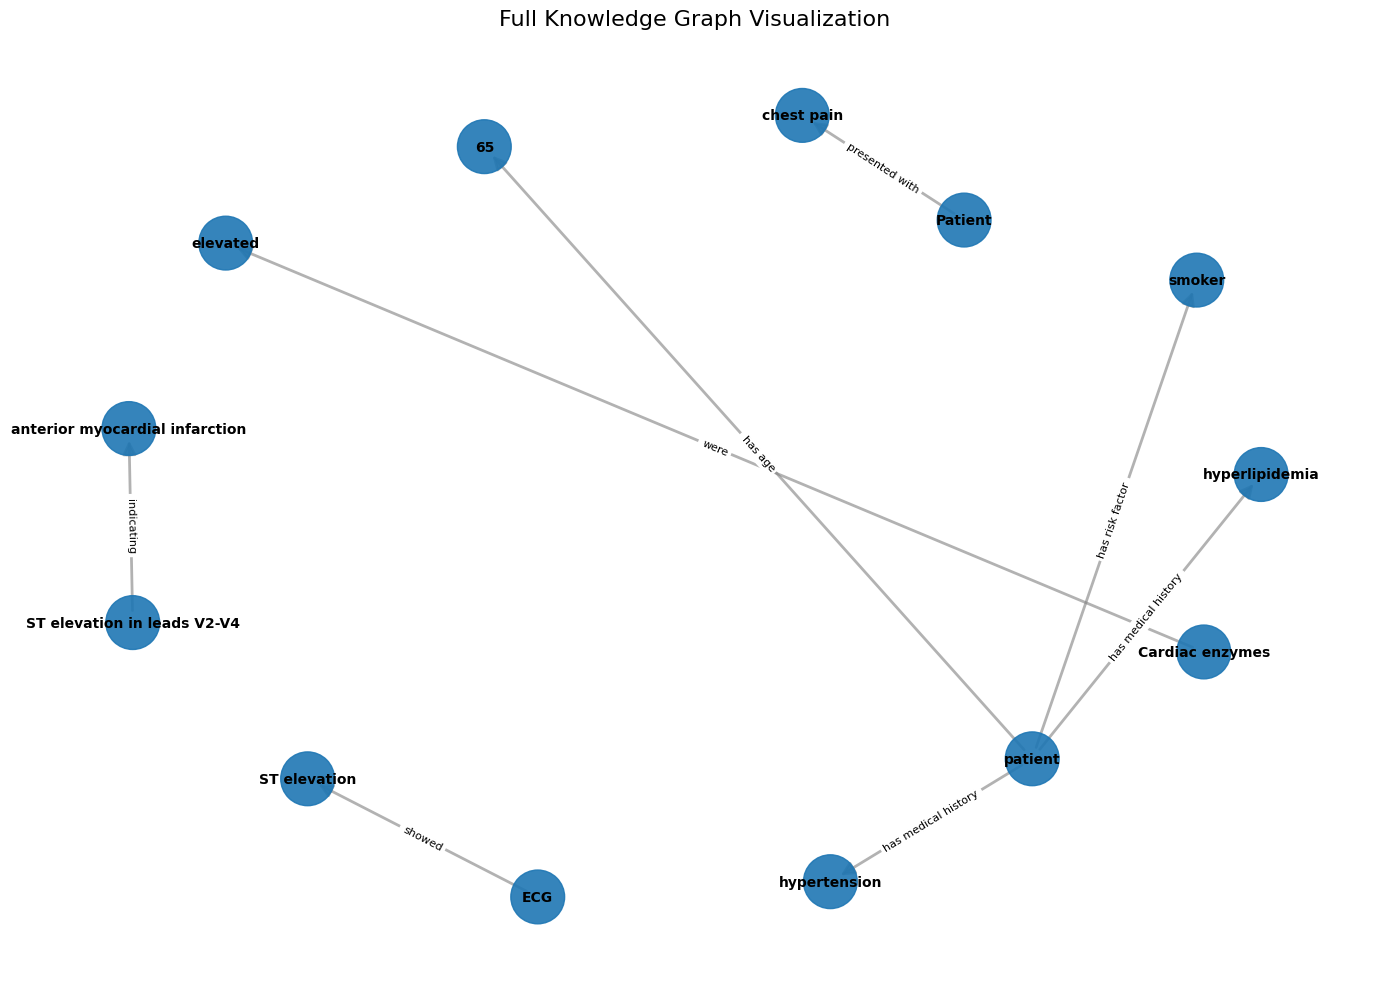


Visualizing subgraph centered around 'Patient'...


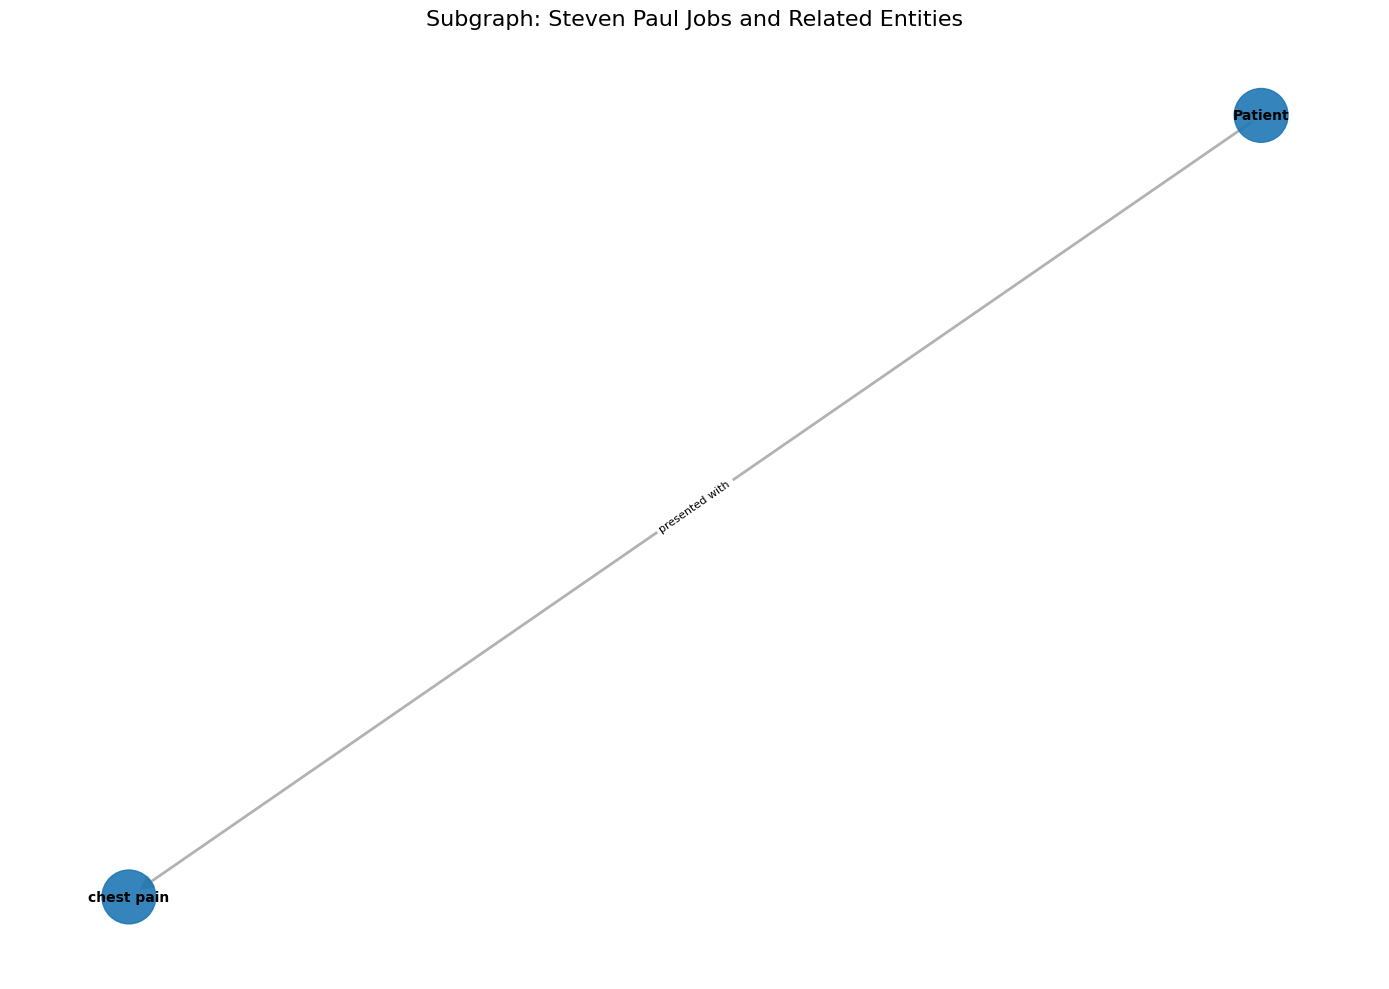

In [43]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML
import numpy as np

def visualize_triplets_graph(triplets_df, title="Knowledge Graph Visualization"):
    """
    Visualize triplets as a graph using NetworkX and Matplotlib

    Args:
        triplets_df: DataFrame with columns ['subject', 'relation', 'object']
        title: Title for the plot
    """
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes and edges from triplets
    for _, row in triplets_df.iterrows():
        subject = row['subject']
        relation = row['relation']
        object_ = row['object']

        # Add nodes
        G.add_node(subject, type='entity', label=subject)
        G.add_node(object_, type='entity', label=object_)

        # Add edge with relation as attribute
        G.add_edge(subject, object_, relation=relation)

    # Set up the plot
    plt.figure(figsize=(14, 10))

    # Choose layout
    pos = nx.spring_layout(G, k=3, iterations=50)

    # Draw nodes
    node_colors = ['#1f77b4' if G.nodes[node]['type'] == 'entity' else '#ff7f0e'
                   for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                          node_size=1500, alpha=0.9)

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.6, edge_color='gray',
                          arrows=True, arrowsize=20, arrowstyle='-|>')

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    # Draw edge labels (relations)
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)

    plt.title(title, size=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return G

def visualize_triplets_interactive(triplets_df, title="Interactive Knowledge Graph"):
    """
    Create an interactive HTML visualization using Plotly
    """
    try:
        import plotly.graph_objects as go
        import plotly.express as px

        # Create a directed graph
        G = nx.DiGraph()

        # Add nodes and edges from triplets
        for _, row in triplets_df.iterrows():
            subject = row['subject']
            relation = row['relation']
            object_ = row['object']

            G.add_node(subject, type='subject')
            G.add_node(object_, type='object')
            G.add_edge(subject, object_, relation=relation)

        # Position nodes using spring layout
        pos = nx.spring_layout(G, dim=3)

        # Extract coordinates
        x_nodes = [pos[node][0] for node in G.nodes()]
        y_nodes = [pos[node][1] for node in G.nodes()]
        z_nodes = [pos[node][2] for node in G.nodes()]

        # Node colors based on type
        node_colors = ['red' if G.nodes[node]['type'] == 'subject' else 'blue'
                      for node in G.nodes()]

        # Create node trace
        node_trace = go.Scatter3d(
            x=x_nodes, y=y_nodes, z=z_nodes,
            mode='markers+text',
            marker=dict(size=10, color=node_colors),
            text=list(G.nodes()),
            textposition="middle center"
        )

        # Create edge traces
        x_edges, y_edges, z_edges = [], [], []
        for edge in G.edges():
            x_coords = [pos[edge[0]][0], pos[edge[1]][0], None]
            y_coords = [pos[edge[0]][1], pos[edge[1]][1], None]
            z_coords = [pos[edge[0]][2], pos[edge[1]][2], None]

            x_edges.extend(x_coords)
            y_edges.extend(y_coords)
            z_edges.extend(z_coords)

        edge_trace = go.Scatter3d(
            x=x_edges, y=y_edges, z=z_edges,
            mode='lines',
            line=dict(width=3, color='gray'),
            hoverinfo='none'
        )

        # Create figure
        fig = go.Figure(data=[edge_trace, node_trace])

        # Update layout
        fig.update_layout(
            title=title,
            showlegend=False,
            scene=dict(
                xaxis=dict(showbackground=False),
                yaxis=dict(showbackground=False),
                zaxis=dict(showbackground=False)
            ),
            margin=dict(l=0, r=0, b=0, t=40)
        )

        fig.show()

    except ImportError:
        print("Plotly not available, using static visualization instead.")
        visualize_triplets_graph(triplets_df, title)

def create_subgraph(triplets_df, seed_entities=None, max_depth=2):
    """
    Create a subgraph centered around specific entities

    Args:
        triplets_df: DataFrame with columns ['subject', 'relation', 'object']
        seed_entities: List of entities to center the subgraph around (None means all)
        max_depth: Maximum depth to expand from seed entities
    """
    G_full = nx.DiGraph()

    # Add all edges to full graph
    for _, row in triplets_df.iterrows():
        subject = row['subject']
        relation = row['relation']
        object_ = row['object']

        G_full.add_node(subject)
        G_full.add_node(object_)
        G_full.add_edge(subject, object_, relation=relation)

    if seed_entities is None:
        # Use all nodes if no seed specified
        nodes_to_include = set(G_full.nodes())
    else:
        # Find nodes within max_depth from seed entities
        nodes_to_include = set(seed_entities)
        current_frontier = set(seed_entities)

        for _ in range(max_depth):
            next_frontier = set()
            for node in current_frontier:
                # Add neighbors (both predecessors and successors)
                next_frontier.update(G_full.predecessors(node))
                next_frontier.update(G_full.successors(node))

            # Filter out already included nodes
            next_frontier -= nodes_to_include
            nodes_to_include.update(next_frontier)
            current_frontier = next_frontier

    # Create subgraph
    subgraph = G_full.subgraph(nodes_to_include).copy()

    # Convert back to DataFrame format for visualization
    subgraph_triplets = []
    for u, v, attrs in subgraph.edges(data=True):
        subgraph_triplets.append({
            'subject': u,
            'relation': attrs.get('relation', 'related_to'),
            'object': v
        })

    return pd.DataFrame(subgraph_triplets), subgraph

# Example usage with the triplets from previous extraction
def example_visualization():
    # Assuming you have triplets_df from the previous extraction
    # For demonstration, let's create a sample DataFrame similar to what would be generated
    # Use the actual extracted triplets
    actual_triplets = extractor.triplets_df[['subject', 'relation', 'object']]

    print("Visualizing the knowledge graph...")
    visualize_triplets_graph(actual_triplets, "Full Knowledge Graph Visualization")

    # Create and visualize a subgraph centered around "Patient"
    subgraph_triplets, subgraph = create_subgraph(
        actual_triplets,
        seed_entities=['Patient'],
        max_depth=1
    )

    print("\nVisualizing subgraph centered around 'Patient'...")
    visualize_triplets_graph(
        subgraph_triplets,
        "Subgraph: Steven Paul Jobs and Related Entities"
    )

    return actual_triplets, subgraph_triplets

# Run example
sample_triplets, subgraph_triplets = example_visualization()

## Save interactive graph HTML

In [31]:
!pip install networkx pyvis --quiet

Visualizing the knowledge graph using Matplotlib...


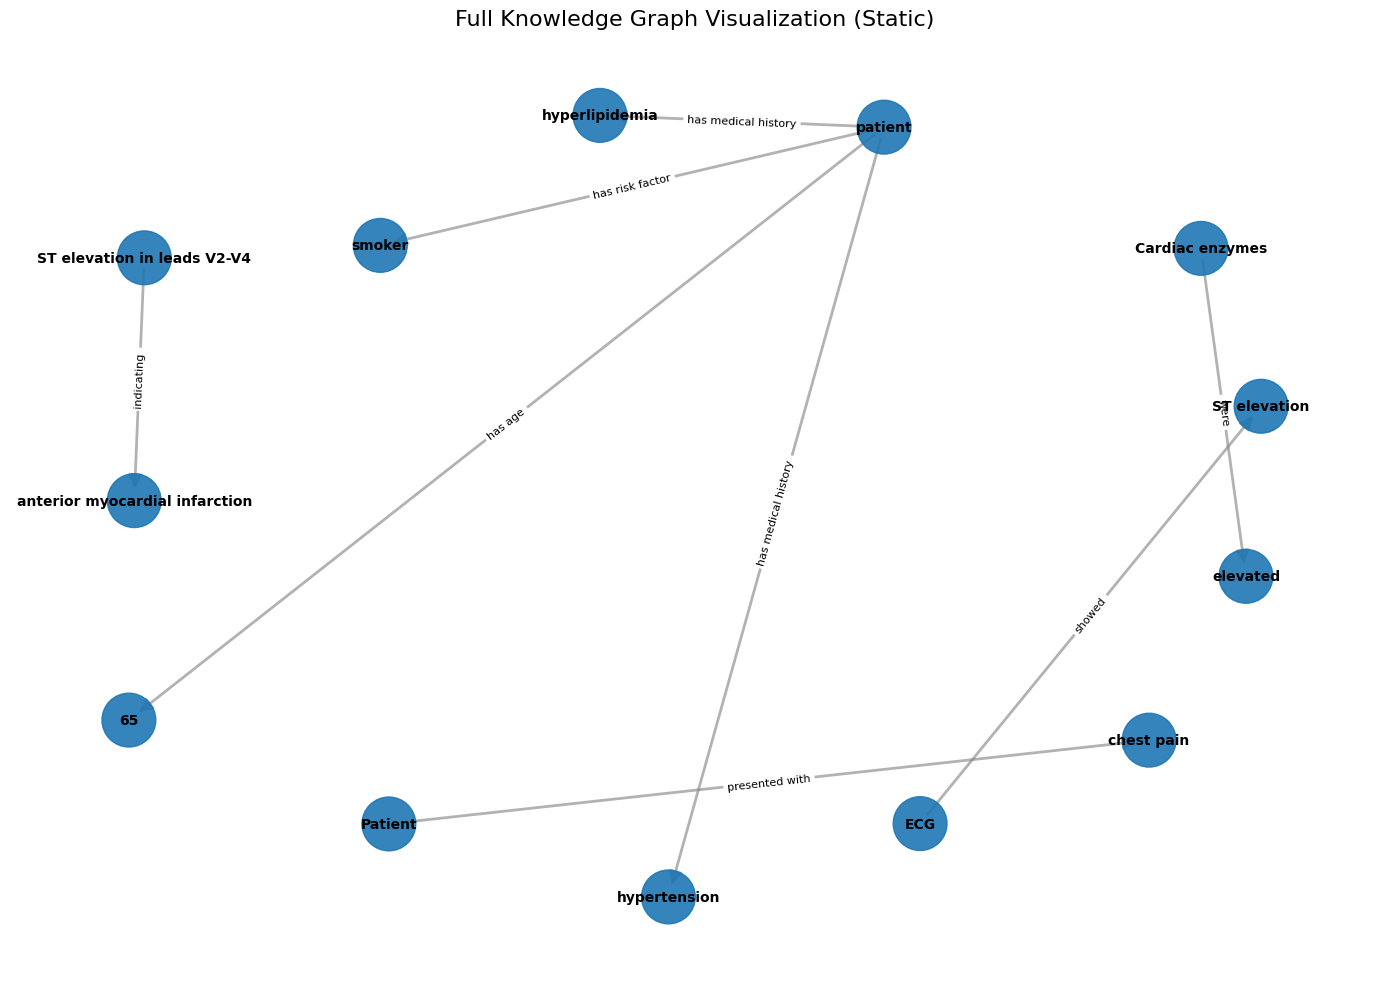


Visualizing subgraph centered around 'Patient' using Matplotlib...


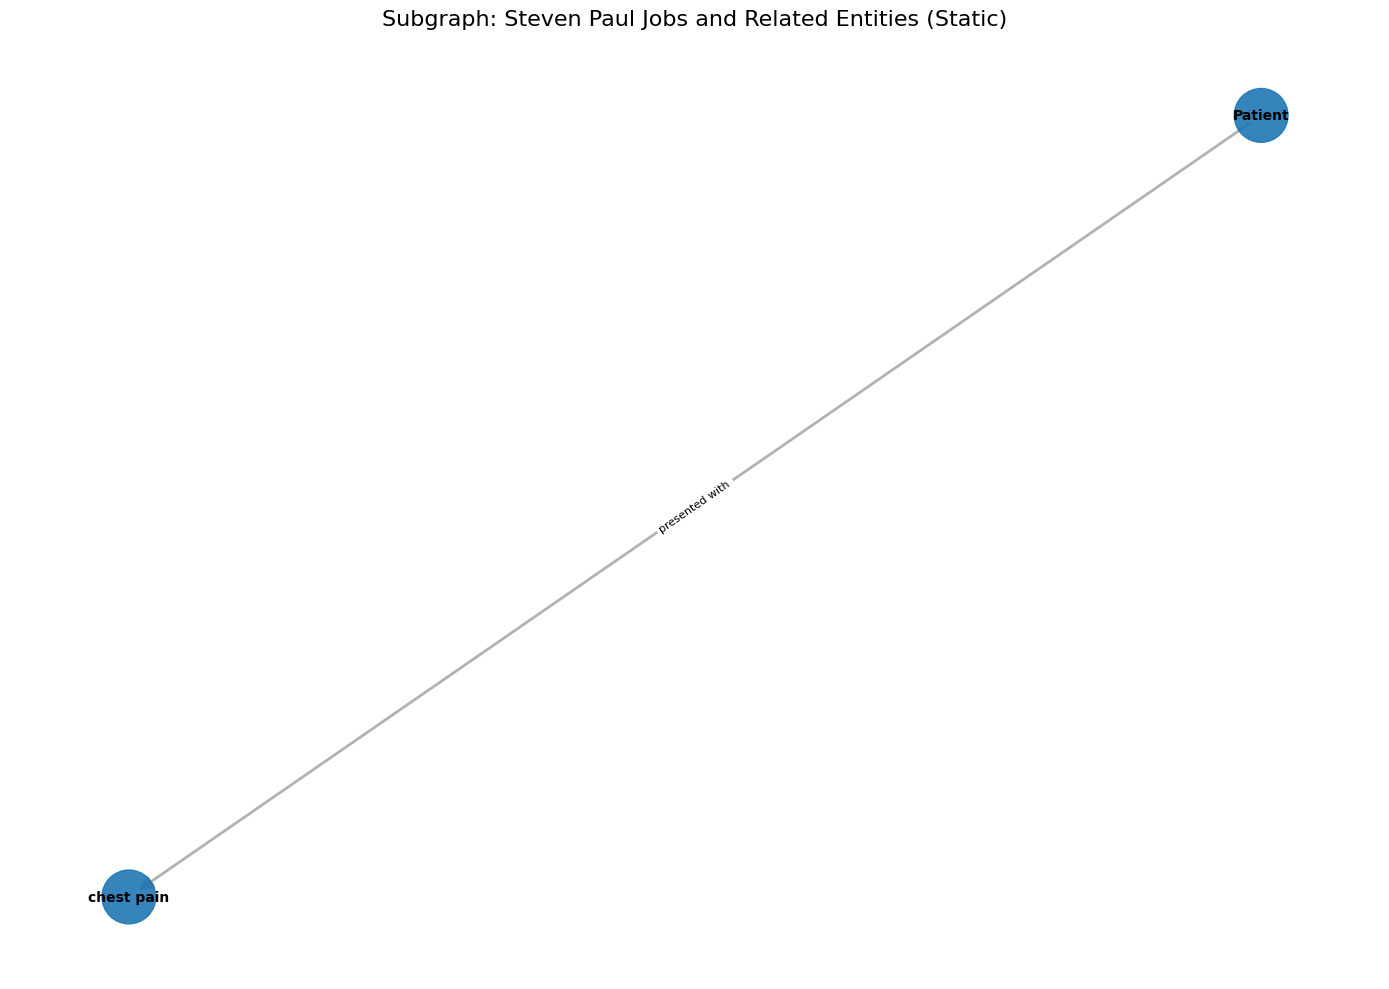

In [40]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming extractor and visualization functions are defined in previous cells
# Use the actual extracted triplets
actual_triplets = extractor.triplets_df[['subject', 'relation', 'object']]

print("Visualizing the knowledge graph using Matplotlib...")
visualize_triplets_graph(actual_triplets, "Full Knowledge Graph Visualization (Static)")

# Create and visualize a subgraph centered around "Steven Paul Jobs"
subgraph_triplets, subgraph = create_subgraph(
    actual_triplets,
    seed_entities=['Patient'],
    max_depth=1
)

print("\nVisualizing subgraph centered around 'Patient' using Matplotlib...")
visualize_triplets_graph(
    subgraph_triplets,
    "Subgraph: Steven Paul Jobs and Related Entities (Static)"
)


In [41]:
import networkx as nx
from pyvis.network import Network

# Create a NetworkX graph
G = nx.DiGraph()

# Add nodes and edges from the DataFrame
for _, row in extractor.triplets_df.iterrows():
    subject = row['subject']
    relation = row['relation']
    obj = row['object']

    # Add nodes (subject and object)
    G.add_node(subject, title=subject, label=subject, group='subject', size=20)
    G.add_node(obj, title=obj, label=obj, group='object', size=15)

    # Add edge (relation)
    G.add_edge(subject, obj, title=relation, label=relation)

print("NetworkX graph created with nodes and edges.")

# Convert to PyVis network for visualization
net = Network(notebook=True, directed=True, cdn_resources='remote', height="750px", width="100%")
net.from_nx(G)

# Save the interactive graph to an HTML file
output_filename = 'knowledge_graph.html'
net.show(output_filename)

print(f"Interactive knowledge graph saved to {output_filename}")

NetworkX graph created with nodes and edges.
knowledge_graph.html
Interactive knowledge graph saved to knowledge_graph.html
